In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import phik
from phik.report import plot_correlation_matrix
from phik import report
import shap

In [2]:
df = pd.read_csv('base_dt.csv')
df.head(3)

,car_id,model,car_type,fuel_type,car_rating,riders,target_reg,target_class,total_car_age,servis_car_age,...,max_car_speed,count_car_rides,upquart_car_speed,start_car_devnorm,driver_range,active_ride,accident_rate,worker_experience,work_meanduration_car,month_top_carfix
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,76163,108.53,another_bug,8,2,...,180.855726,169.0,105.000000,0.000,1097.0,0.729018,0.007975,275.685714,26.657143,4.0
1,O41613818T,VW Polo VI,economy,petrol,3.90,78218,35.20,electro_bug,8,2,...,187.862734,174.0,109.660112,-7.057,1187.5,0.694342,0.006158,264.628571,24.942857,1.0
2,d-2109686j,Renault Sandero,standart,petrol,6.30,23340,38.62,gear_stick,11,6,...,102.382857,165.0,74.000000,0.000,1206.0,0.758170,0.007472,268.314286,26.142857,3.0


In [3]:
df.drop(columns=['car_id'], inplace=True, errors = 'ignore') # Удаляю признак car_id, т.к. он не несет смысловой нагрузки
pd.set_option('display.max_info_columns', 23)
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   model                  2337 non-null   object 
 1   car_type               2337 non-null   object 
 2   fuel_type              2337 non-null   object 
 3   car_rating             2337 non-null   float64
 4   riders                 2337 non-null   int64  
 5   target_reg             2337 non-null   float64
 6   target_class           2337 non-null   object 
 7   total_car_age          2337 non-null   int64  
 8   servis_car_age         2337 non-null   int64  
 9   shift_car_devnorm      2337 non-null   float64
 10  min_car_rating         2337 non-null   float64
 11  mean_car_rating        2337 non-null   float64
 12  sum_car_distance       2337 non-null   float64
 13  max_car_speed          2337 non-null   float64
 14  count_car_rides        2337 non-null   float64
 15  upqu

In [9]:
df['month_top_carfix'] = df['month_top_carfix'].astype(str) # Представляет собой нумерацию месяцев от 1 до 12, что является категориальным признаком

In [4]:
from catboost import CatBoostRegressor, Pool, CatBoostClassifier
from sklearn.model_selection import train_test_split

In [11]:
drop_cols = ['target_class', 'target_reg']
cat_cols = ['car_type', 'fuel_type', 'model', 'month_top_carfix']

X = df.drop(drop_cols, axis=1, errors = 'ignore')
y = df['target_class'].fillna(0)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
model = CatBoostClassifier(random_state=42,
                           cat_features=cat_cols,
                           thread_count=-1)
model.fit(X_train, y_train, 
          eval_set=(X_test, y_test),
          verbose=100, plot=False, 
          early_stopping_rounds=100)

accuracy = model.score(X_test, y_test)
print(f"Accuracy: {accuracy:.2f}")

Learning rate set to 0.109335
0:	learn: 1.7297205	test: 1.7267619	best: 1.7267619 (0)	total: 159ms	remaining: 2m 38s


100:	learn: 0.0964897	test: 0.1295165	best: 0.1294841 (99)	total: 6.61s	remaining: 58.8s
200:	learn: 0.0567358	test: 0.1082516	best: 0.1082378 (199)	total: 13.2s	remaining: 52.5s
300:	learn: 0.0380468	test: 0.1019380	best: 0.1017947 (299)	total: 19.7s	remaining: 45.8s
400:	learn: 0.0281001	test: 0.1000981	best: 0.0998096 (390)	total: 26.2s	remaining: 39.2s
500:	learn: 0.0219133	test: 0.0991053	best: 0.0985681 (477)	total: 32.7s	remaining: 32.6s
600:	learn: 0.0175453	test: 0.0975568	best: 0.0974989 (598)	total: 39.1s	remaining: 26s
700:	learn: 0.0148012	test: 0.0991127	best: 0.0973811 (609)	total: 45.5s	remaining: 19.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.09738106392
bestIteration = 609

Shrink model to first 610 iterations.
Accuracy: 0.97


In [14]:
fi = model.get_feature_importance(prettified=True)
fi

,Feature Id,Importances
0,accident_rate,21.307536
1,count_car_rides,20.399171
2,max_car_speed,16.276186
3,upquart_car_speed,13.040875
4,mean_car_rating,6.836047
5,shift_car_devnorm,6.442116
6,start_car_devnorm,3.048733
7,driver_range,2.193735
8,month_top_carfix,2.170263
9,car_type,1.851363


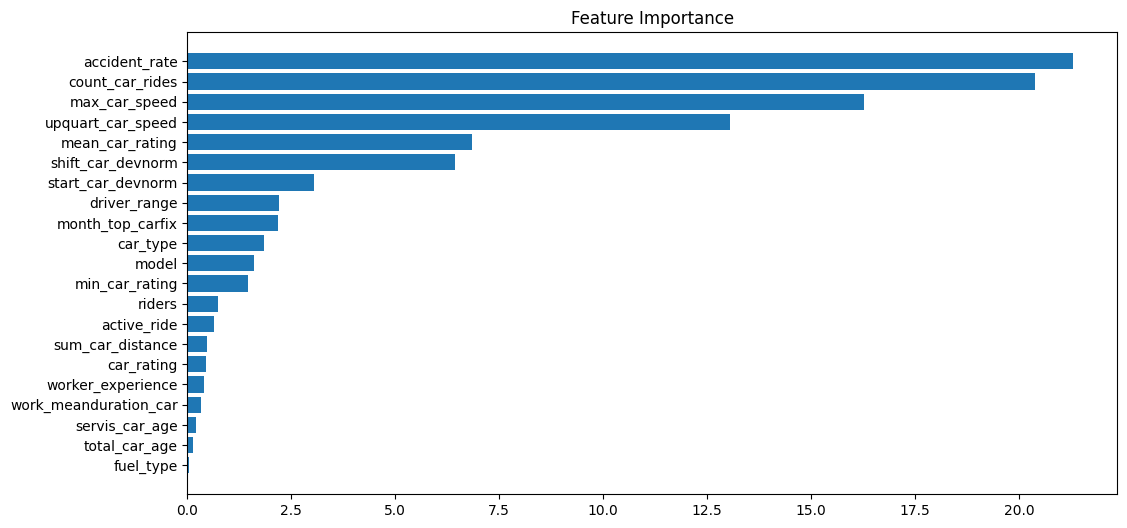

In [15]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance');

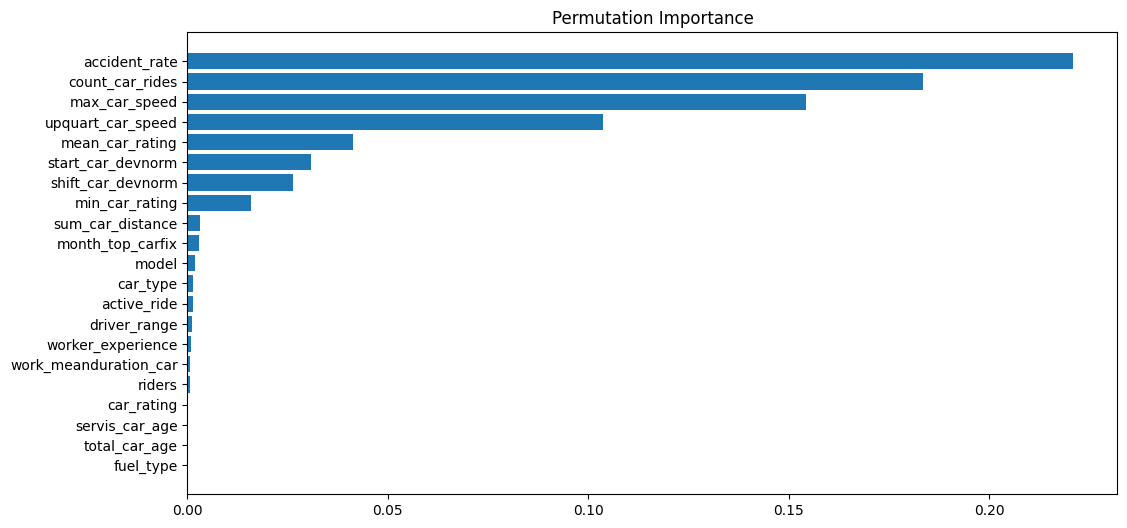

In [16]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Permutation Importance');

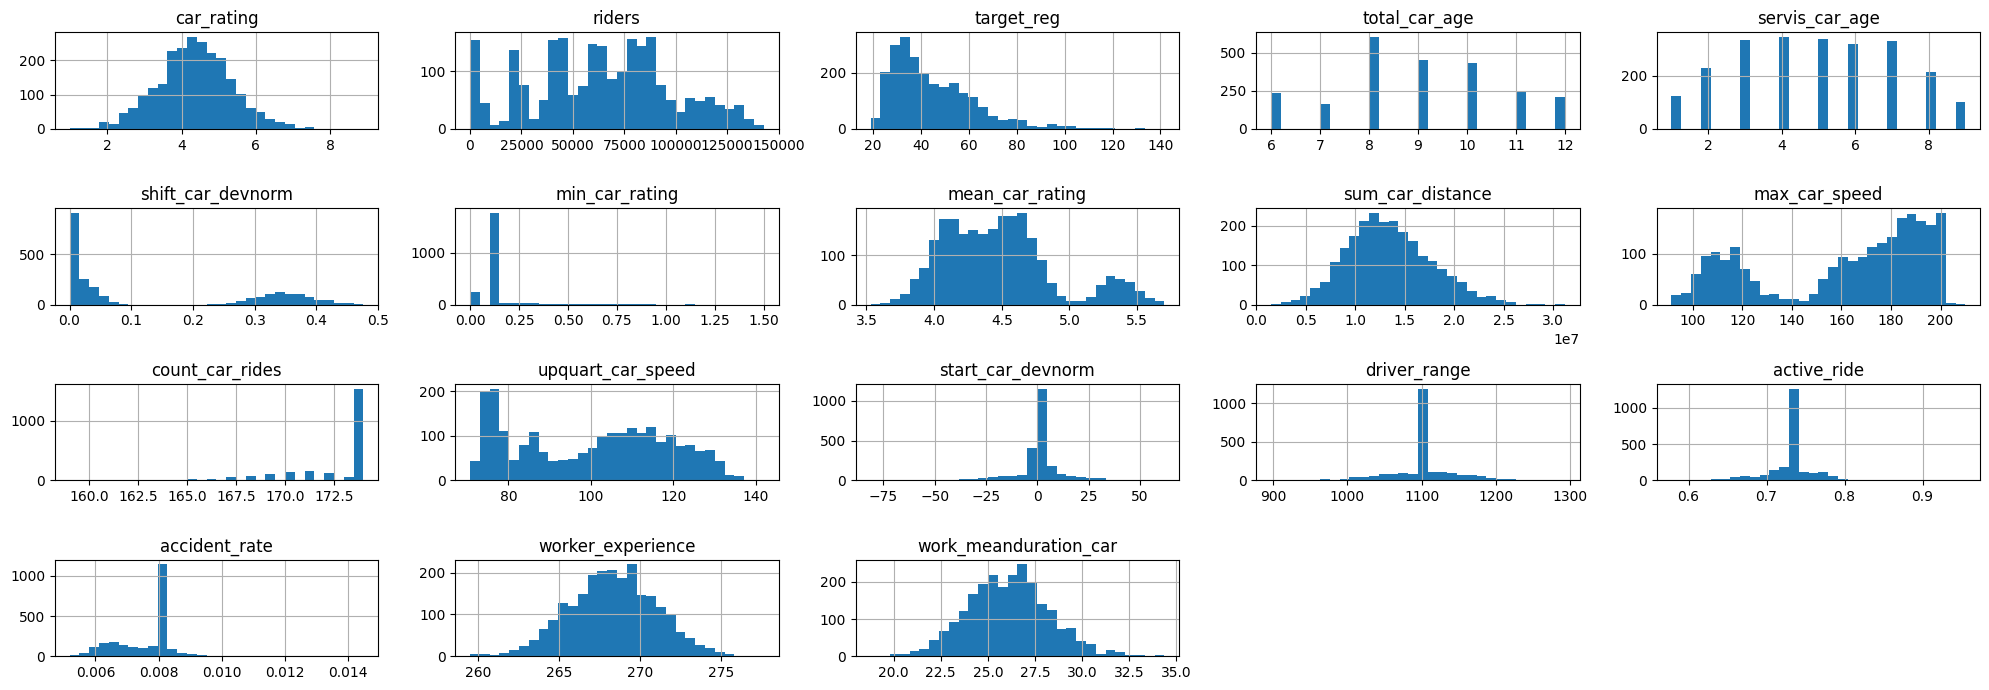

In [15]:
df.hist(figsize = (20, 7), layout = (-1, 5), bins=30);
plt.tight_layout()

interval columns not set, guessing: ['car_rating', 'riders', 'target_reg', 'total_car_age', 'servis_car_age', 'shift_car_devnorm', 'min_car_rating', 'mean_car_rating', 'sum_car_distance', 'max_car_speed', 'count_car_rides', 'upquart_car_speed', 'start_car_devnorm', 'driver_range', 'active_ride', 'accident_rate', 'worker_experience', 'work_meanduration_car']


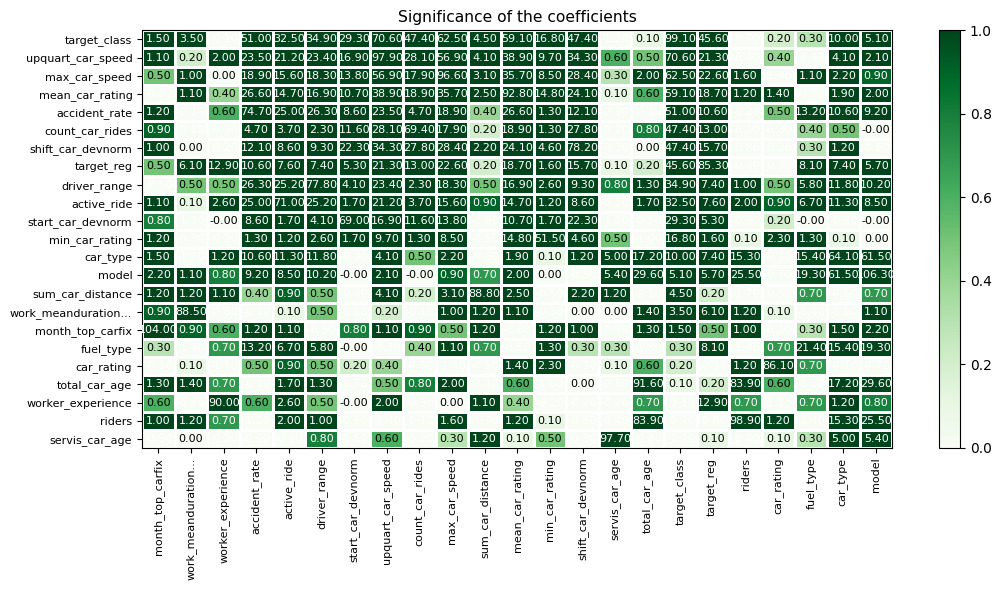

In [16]:
significance_overview = df.significance_matrix().fillna(0).round(1).sort_values('target_class')

plot_correlation_matrix(significance_overview.values,
                        x_labels=significance_overview.columns,
                        y_labels=significance_overview.index,
                        vmin=0, vmax=1, color_map="Greens",
                        title="Significance of the coefficients",
                        usetex=False, fontsize_factor=0.8, figsize=(11, 6))
plt.tight_layout()

In [17]:
# Фильтрация значений для строки 'target_reg'
target_reg_values = significance_overview.loc['target_reg']


# Создание масок для условий
mask_group_1 = (target_reg_values >= 3.84) & (target_reg_values <= 6.63)
mask_group_2 = target_reg_values > 6.63

# Создание пустых списков для групп
group_1 = []
group_2 = []

# Заполнение групп на основе условий
for column in target_reg_values.index:
    if mask_group_2[column]:
        group_2.append(column)
    elif mask_group_1[column]:
        group_1.append(column)

print("Group 1:", group_1)
print("Group 2:", group_2)

Group 1: ['model', 'start_car_devnorm', 'work_meanduration_car']
Group 2: ['car_type', 'fuel_type', 'target_reg', 'target_class', 'shift_car_devnorm', 'mean_car_rating', 'max_car_speed', 'count_car_rides', 'upquart_car_speed', 'driver_range', 'active_ride', 'accident_rate', 'worker_experience']


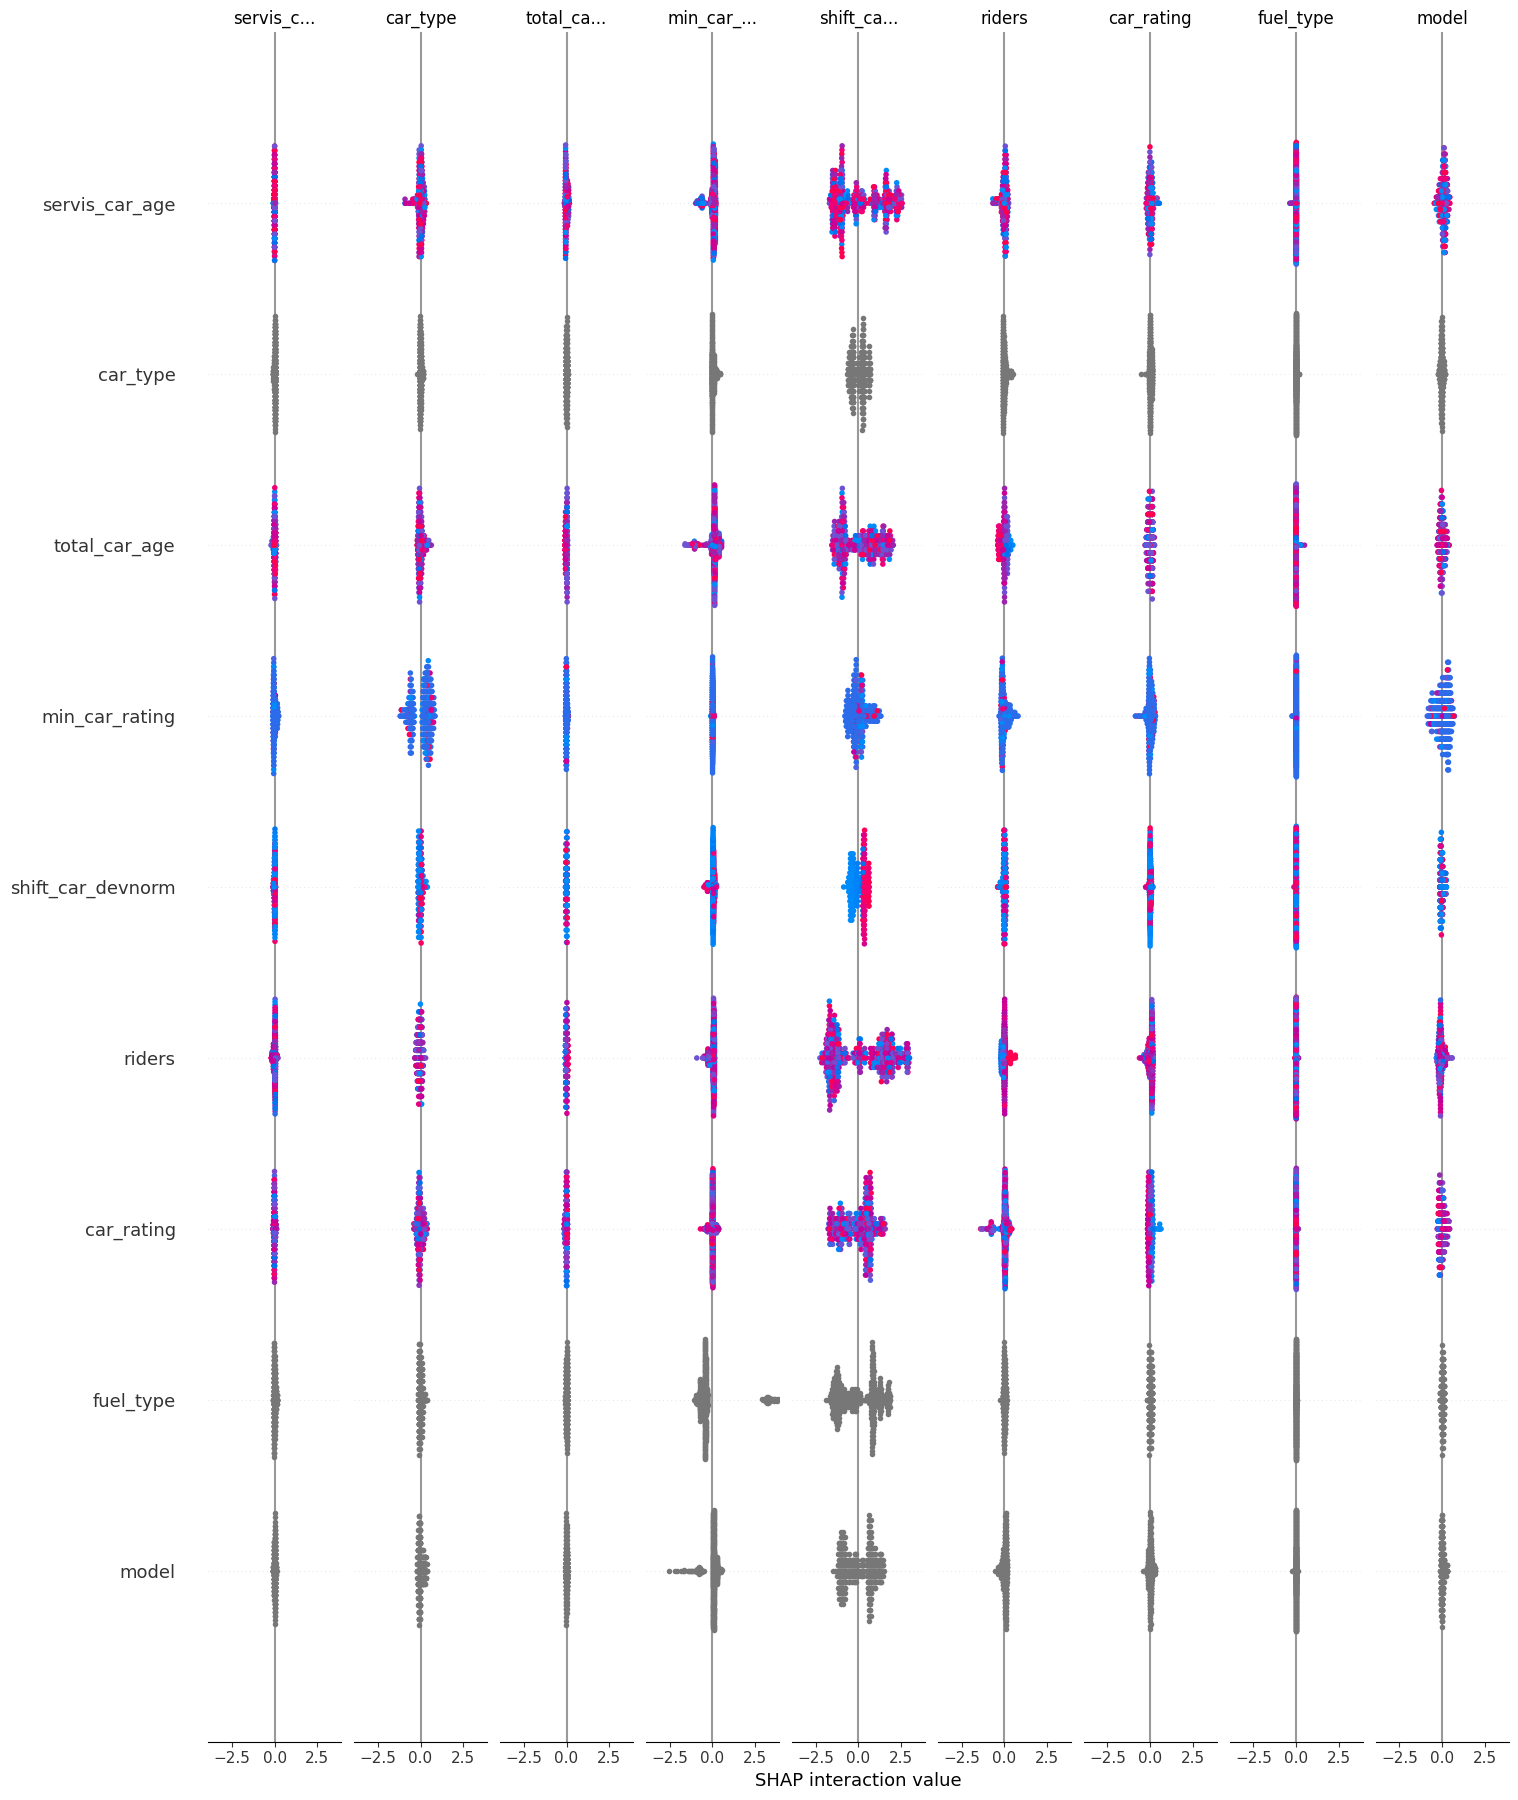

In [17]:
explainer = shap.TreeExplainer(model)

val_dataset = Pool(data=X_test, label=y_test, cat_features=cat_cols)
shap_values = explainer.shap_values(val_dataset)
shap.summary_plot(shap_values, X_test, max_display = 22)

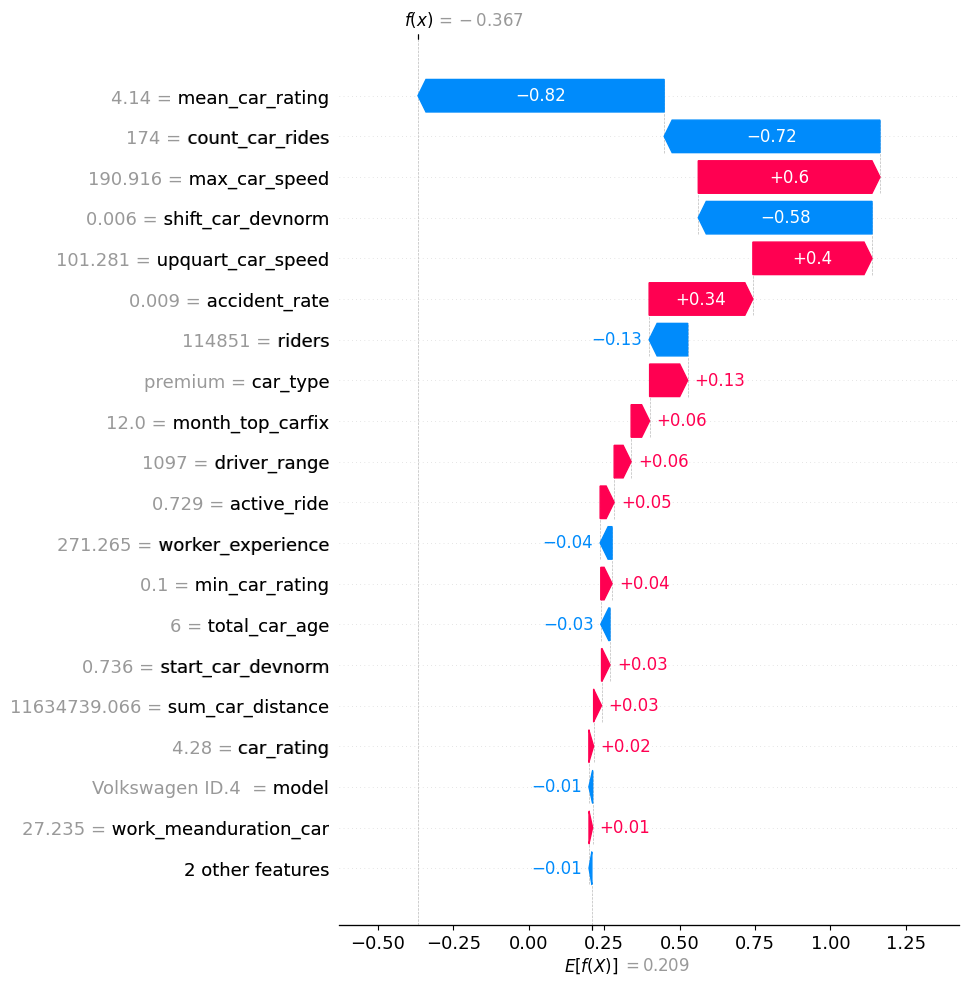

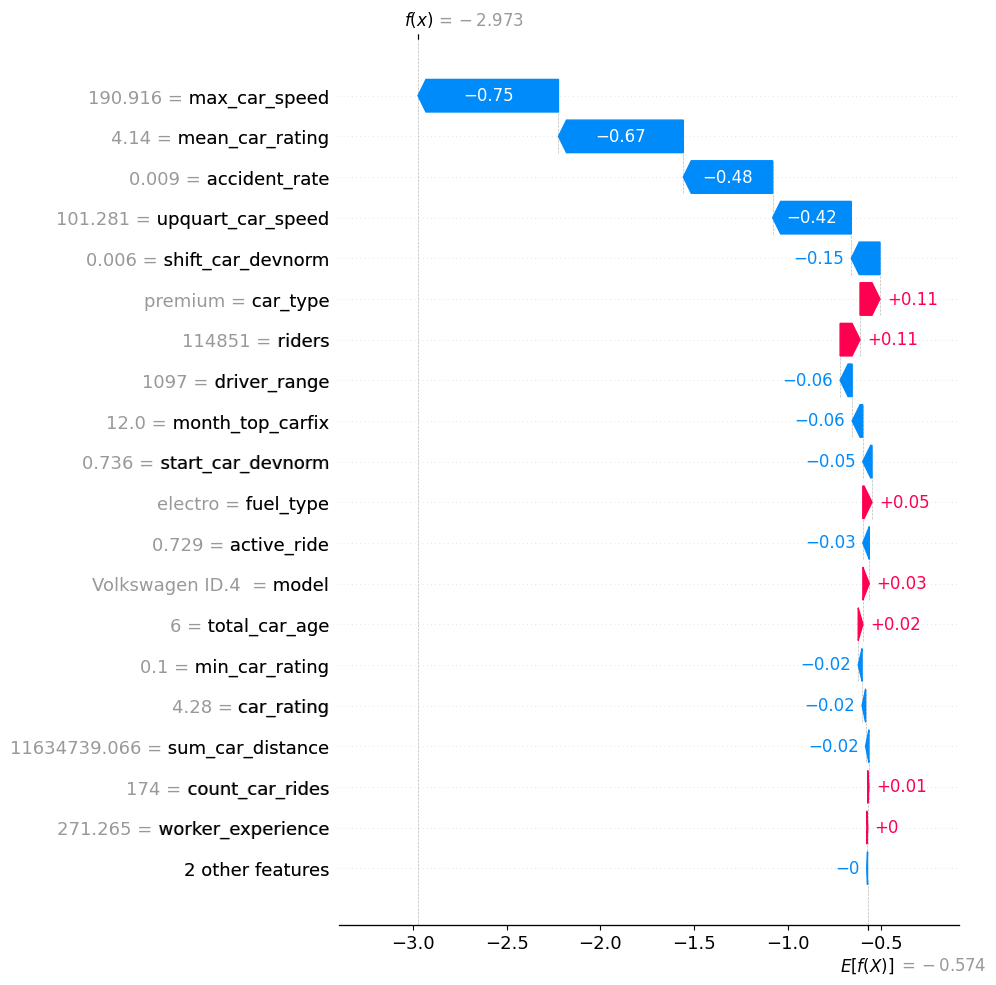

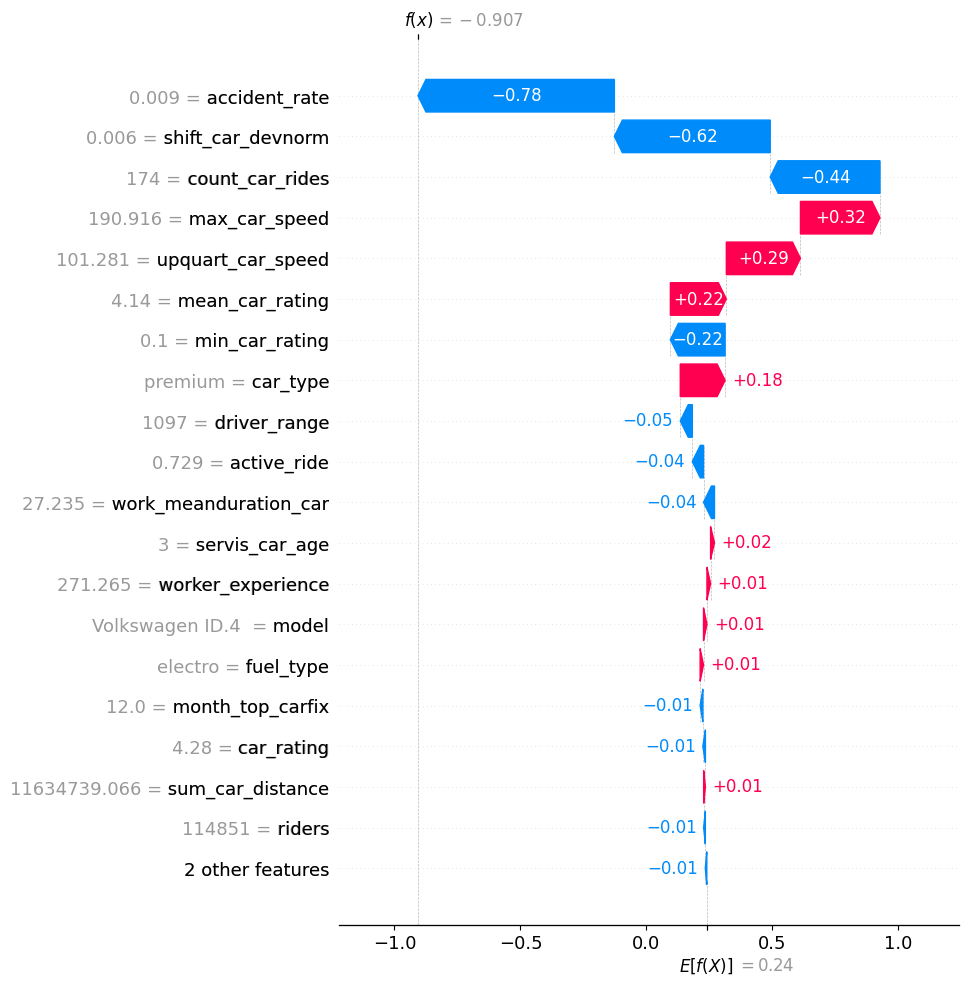

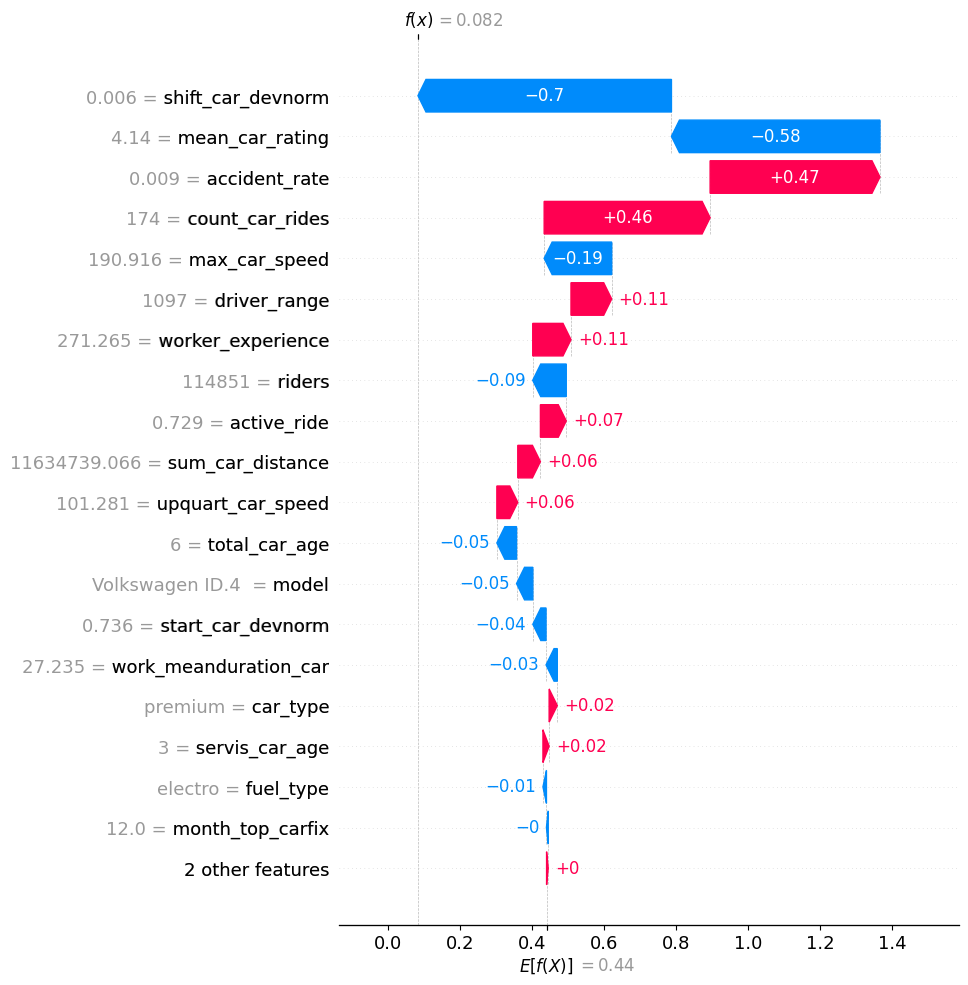

In [18]:
s_values = explainer(X_test)
for i in range(4):
    shap.waterfall_plot(s_values[0][:, i], max_display=20)

##### Из анализа графиков, (feature_importance, permutation_importance, significance_matrix), методом голосования выделил топ - 8 признаков: 
'max_car_speed',  'mean_car_rating',  'shift_car_devnorm',  'count_car_rides',  'upquart_car_speed',  'accident_rate',  'car_type',  'start_car_devnorm'
На всех трех графиках все эти признаки согласуются.
На графиках waterfall_plot:
 - признак max_car_speed показывает положительное и отрицательное влияние,
 - mean_car_rating - 3 случая сильный отрицательный и 1 небольшой положитедный эффект,
 - shift_car_devnorm - показывает сильный отрицательный эффект,
 - count_car_rides - показывает сильный отрицательный и положительный, в одном случае почти нулевой эффект,
 - upquart_car_speed - в целом дублирует max_car_speed, но дает более сбалансированный результат, лишь в одном случае амбивалентный результат,
 - accident_rate - показывает положительное и отрицательное влияние,
 - car_type - по всем графикам незначительный положитедный эффект,
 - start_car_devnorm - по всем графикам незначительный эффект.
* Можно сделать вывод, что  следует более детально изучить эти признаки, учитывая их взаимодействие друг с другом, чтобы улучшить точность модели.